# 0. Imports, Set Up

The cell below provides all the imports necessary to run the notebook. It also includes a random state `RS` that can be used to replicate its results.  

In [1]:
import pandas as pd
import numpy as np
import random as rand
import modsim as ms
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

RS = np.random.RandomState(19)

# 1. Introduction

More so than almost any other board game in existence, chess has a rich history. Belived to be invented in India over 1,500 years ago where it was known as Chaturanga, the game slowly spread to every corner of the world and has not changed much from its original version. Despite the game being played for over a millenia, chess has recently undergone a surge in popularity thanks to Netflix's "The Queen's Gambit", people looking for new hobbies during COVID lockdowns, and the success of platforms such as [chess.com](https://www.chess.com/), which allows users to play with each other so long as they have an internet connection. Amazingly, since January 2020, [more than 102 million users](https://www.wuft.org/news/2023/02/17/chess-grows-more-popular-with-chess-com-experiencing-server-issues-due-to-high-user-volume/) have signed up to use the site. 

Another, maybe less glamorous reason for chess's recent foray into the spotlight has been a cheating scandal involving chess's best known and current highest rated player, the Norwegian grandmaster Magnus Carlsen. In September 2022 in St. Louis, during a chess tournament known as the Sinquefield Cup, Magnus Carlsen was defeated by American grandmaster Hans Niemann. Though Magnus was the higher rated player, he is not immune to losing, and many people viewed the game as a well fought underdog victory for Niemann. However, the next day Magnus dropped out of the tournament, leading many to believe that Niemann had cheated. In their next game together at a different tournament, Carlsen resigned after only one move, further validating these rumors. Finally, these rumors were confirmed by Carlsen himself when he said in a [tweet](https://twitter.com/MagnusCarlsen/status/1574482694406565888) that he believed Niemann not only cheated in their game at the Sinqefield cup, but at other times during his career. This gave rise to some [less than flattering rumors](https://www.insider.com/chess-feud-hans-niemann-magnus-carlsen-anal-beads-rumor-explained-2022-9) about how Niemann might have cheated during his game with Carlsen, eventually pushing Niemann to file a \\$100 million defamation suit against Carlsen. As of this writing, the outcome of this lawsuit has not yet been determined.

So, did Niemann really cheat against Carlsen? While we will likely never get a concrete answer to this question, we can use simulation and statistical analysis in an attempt to provide evidence either for or against these cheating claims. Outside of this specific scandal, cheating in chess is actually quite common: computers have reached the point where they are much better than humans at chess, and someone who is looking to cheat can easily use a chess engine to in order to figure out what the best moves are at any point during a game. As such, the work done here attempts to build a way to simulate chess tournaments in hopes that it can be used to help evaluate cheating claims.

# 2. Building the Simulation

This section will review the entire process that was carried out to build a simulation that can replicate the results of chess tournaments. 

## 2.1. Initial Conditions

Chess tournaments can have a variety of different formats (i.e. number of players, rounds, etc.) and as such we will need to establish a list of modifiable parameters that we can use to replicate how the tournament is played. The cell below defines these parameters, which can then be used to create a system that represents the chess tournament a user is trying to replicate. Each of these parameters is exaplained below:

* `POINTS_W`: The number of points a player recieves for winning a match.
* `POINTS_D`: The number of points a player recieves for drawing a match. 
* `POINTS_L`: The number of points a player receives for losing a match. 
* `RNDS`: The number of rounds in the tournament (how many times two players will player a match together). 
* `NUM_PLAYERS`: The number of players in the tournament. This value also determines the number of total matches that will be played in the tournament via the following: for $N$ total players with $R$ rounds, the number of total matches $m = R \cdot \sum_{i=1}^{N-1} i$. 
* `MAX_ELO`: The maximum elo possible allowed for tournament players.
* `MIN_ELO`: The minimum possible elo allowed for tournament players.
* `MAX_DRAW_P`: The maximum possible draw percentage that any two players can have when playing each other.
* `MIN_DRAW_P`: The minimum possible draw percentage that any two players can have when playing each other.
* `K = 30`: A scale factor that determines how many elo points are lost and won by two players after they complete a game. 

Below, we provide example values for each of the parameters and place them in a `system`. This `system` will be used as an input to the final simulation to ensure it is working correctly.

In [2]:
POINTS_W = 3
POINTS_D = 1
POINTS_L = 0
RNDS = 1
NUM_PLAYERS = 10
MAX_ELO = 3000
MIN_ELO = 2000
MAX_DRAW_P = 0.40
MIN_DRAW_P = 0.20
RNDS = 1
K = 30

inputs = ms.Params(points_w=POINTS_W, points_d=POINTS_D, points_l=POINTS_L,
                   num_players = NUM_PLAYERS, max_elo=MAX_ELO, min_elo=MIN_ELO,
                   max_draw_p=MAX_DRAW_P, min_draw_p=MIN_DRAW_P, rnds=RNDS, k=K)

def make_system(params):
    return ms.System(params)

system = make_system(inputs)

Now that we have defined all the parameters necessary to set up the chess tournament, the function below uses this system to create a list of dictionaries that will hold information for each chess player as they progress through the tournament. The function provides two alternative ways for setting this up, by means of the `method` argument:

* If `method="randomize`, the function will create the required number of players and randomly assign them ELO values between the maximum and minimum allowed ELO. 
* If `method="manual`, the function will allow the user to manually input the player names and their ELO values. Note that these inputted ELOs will still need to be between the maximum and minimum allowed values. 

In [3]:
def initialize_tournament(method, system):
    player_dicts = []
    for i in range(int(system.num_players)):
        if method == 'randomize':        
            player_name = f'player {i}'
            player_elo = RS.randint(system.min_elo, system.max_elo)
            player_dict = {'name': player_name, 'elo': player_elo, 'score': 0}
            player_dicts.append(player_dict)
        elif method == 'manual':
            player_name = input(f'Enter name of player {i}: ')
            player_elo = -1
            while player_elo < system.min_elo or player_elo > system.max_elo:
                player_elo = int(input(f'Enter elo of player {i}: '))
            player_dict = {'name': player_name, 'elo': player_elo, 'score': 0}
            player_dicts.append(player_dict)
        else: 
            print('method argument not recognized. Try "randomize" or "manual."')
            return

    return player_dicts

Below, we see an example implementation of the `intialize_tournament` function. We see that using the `randomize` method returns a list of 10 dictionaries, with players having ELOs between 2,000 and 3,000, as expected. 

In [4]:
initialize_tournament("randomize", system)

[{'name': 'player 0', 'elo': 2605, 'score': 0},
 {'name': 'player 1', 'elo': 2622, 'score': 0},
 {'name': 'player 2', 'elo': 2757, 'score': 0},
 {'name': 'player 3', 'elo': 2354, 'score': 0},
 {'name': 'player 4', 'elo': 2936, 'score': 0},
 {'name': 'player 5', 'elo': 2019, 'score': 0},
 {'name': 'player 6', 'elo': 2308, 'score': 0},
 {'name': 'player 7', 'elo': 2330, 'score': 0},
 {'name': 'player 8', 'elo': 2671, 'score': 0},
 {'name': 'player 9', 'elo': 2834, 'score': 0}]

## 2.2. Simulating the Tournament

Now that we have defined the inital conditions needed to set up the tournament, we can build the pieces that will actually simulate the games being played. The flowchart below visualizes the process that needs to take place for each player as they work their way through the competition:

![title](flowchart.png)


Once "END" is reached for a given player, that player will have a final score for the tournament, and once completed for all players we can compare those final scores to see each player's final rank. The following subsections will go into detail regarding how each part of the process is completed.

### 2.2.1. Expected Score

Explaining the next function requires a little more background knowledge on ELO scores, and how they can be used to calculate winning and losing percentages. Central to the idea of ELO scores is the concept of expected score, a value between 0 and 1 that provides a fraction of how many total points a player should expect to win in a match between another player. For example, if Mangnus Carlsen has expected score of 0.6 when playing against Hikaru Nakamura, he should expect to win 60% of the points for the games they play. The creator of the ELO system, Arpad Elo, assumed that the expected score values would to conform a normal distribution, [but this was modified](https://www.cantorsparadise.com/the-mathematics-of-elo-ratings-b6bfc9ca1dba) by FIDE (the internation chess organization) after empirical results showed a logistic distribution to be a better match. The cell below plots both distributions using a mean $u$ equal to 0 and standard deviation $\sigma$ equal to 1: 

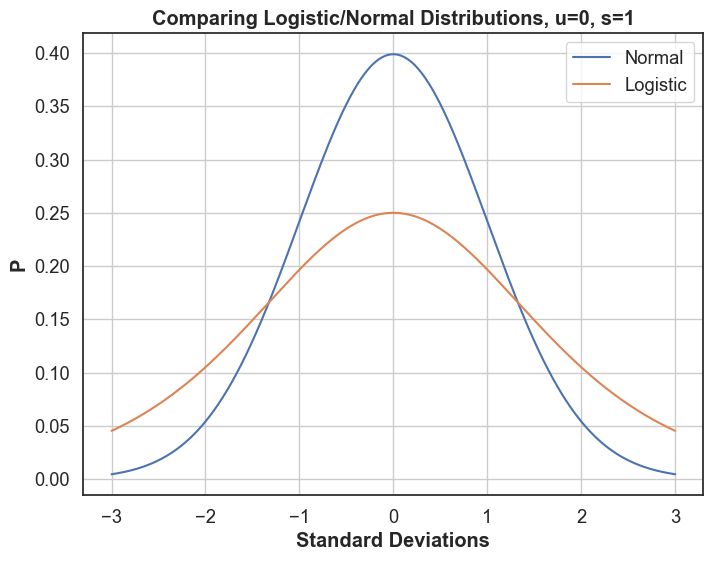

In [5]:
def get_normal(x, u, s):
    pt1 = (s*np.sqrt(2*np.pi))
    pt2 = ((x-u)/s)**2
    return (1/pt1) * np.exp(-0.5 * pt2)

def get_logistic(x, u, s):
    pt1 = np.exp(-(x-u)/s) 
    return pt1 / (s * (1 + pt1) ** 2)

xs = np.linspace(-3, 3, 1000)
ns = [get_normal(x, 0, 1) for x in xs]
ls = [get_logistic(x, 0, 1) for x in xs]

plt.figure(figsize=(8,6))
plt.plot(xs, ns, label='Normal')
plt.plot(xs, ls, label='Logistic')
plt.xlabel('Standard Deviations', fontweight='bold')
plt.ylabel('P', fontweight='bold')
plt.title('Comparing Logistic/Normal Distributions, u=0, s=1', fontweight='bold')
plt.grid()
plt.legend()
plt.show()

As you can see in the plot above, the logistic distribution has "heavier" tails, which means that extreme outcomes are more likely. This behavior was found to better model the outcomes of chess games.

To actually calculate expected score, we must take the cumulative density function of the logistic distribution, with a few modifications. Given two players $A$ and $B$, the expected scores for each ($E_A$ and $E_B$) can be calculated via the following:

$$
\begin{align}
E_A &= 1 + \frac{1}{10^{\frac{R_B-R_A}{400}}} \\
E_B &= 1 + \frac{1}{10^{\frac{R_A-R_B}{400}}} 
\end{align}
$$

where $R_A$ and $R_B$ are the ELO ratings of player A and player B, respectively. This formula is translated into python code below via the `get_expected_score` function, and then used to create an plot of the distribution:

In [6]:
def get_expected_score(player1_elo, player2_elo):
    m = (5 / 6) * (player2_elo - player1_elo) / 400
    return 1 / (1 + 10 ** m)

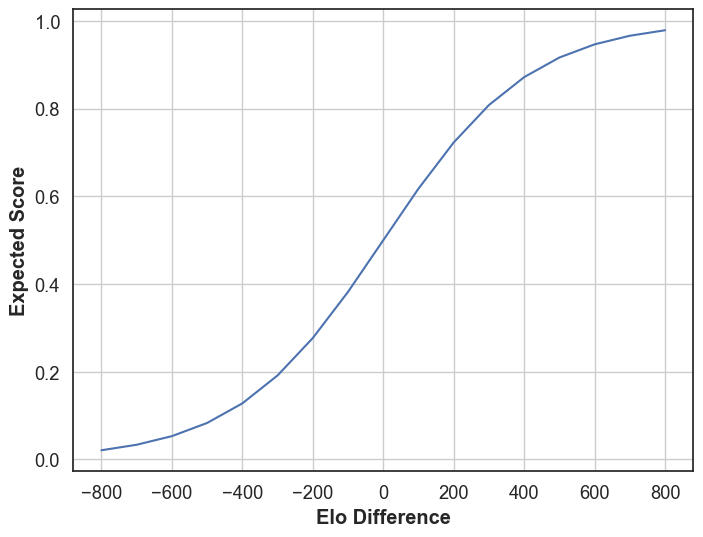

In [7]:
elo_diffs = np.linspace(-800, 800, 17)
win_probs = [get_expected_score(elo_diff, 0) for elo_diff in elo_diffs]

plt.figure(figsize=(8,6))
plt.plot(elo_diffs, win_probs)
plt.xlabel('Elo Difference', fontweight='bold')
plt.ylabel('Expected Score', fontweight='bold')
plt.grid()
plt.show()

The graph above is extremely useful, as it gives us a way of converting ELO difference into expected score. For example, according to the graph, a player who is rated 200 points higher than their opponent should expect to win ~72% of the possible points in the games played between them. 

### 2.2.2. Draw Probability 

Unfortunately, using expected score to randomly determine the outcomes of a match played between two players runs into a fatal flaw: it does not tell us how those points were won. Typically, points can be won by both winning <i>or</i> drawing a match with your opponent. As such, expected score does not actually tell us the probability that a player will win a single game, but is rather equal to player's probability of winning plus half their probability of drawing. There are an infinite number of ways for this to occur: for example, if a player has an 0.6 expected score all of the following scenarios are possible:

1. 60% win probability, 0% draw proabability, 40% loss probability $\rightarrow 0.6 + 0.5 \cdot 0 = 0.6$
2. 40% win probability, 40% draw probability, 20% loss probability $\rightarrow 0.4 + 0.5 \cdot 0.4 = 0.6$
3. 20% win probability, 80% draw probability, 0% loss probability. $\rightarrow 0.2 + 0.5 \cdot 0.8 = 0.6$

As such, in order to estimate the probabilities of winning, drawing, and losing given the ELO difference in a game, we need to devise a way to model the draw probability. Once draw probability is estimated, we can determine the winning and losing probabilities. 

To model draw probability, we can work off of two assumptions, both of which have been [found to be true](https://en.chessbase.com/post/the-elo-rating-system-correcting-the-expectancy-tables): 

* <b>Assumption 1:</b> Players are more likely to draw the more closely rated they are. 
* <b>Assumption 2:</b> Players are more likely to draw if they are both highly rated (i.e. grandmaster level).

Thus, given the ELO difference $d$ and average ELO $a$ between two players, we know that the draw percentage $P(D)$ might have the following format:

$$
\begin{equation}
P(D) \propto \frac{a}{d}
\end{equation}
$$

If we plug in the player's actual ratings we get the following:

$$
\begin{align}
P(D) &\propto \frac{\frac{R_A + R_B}{2}}{|R_A-R_B|} \\
P(D) &\propto \frac{R_A + R_B}{2|R_A-R_B|}
\end{align}
$$

For simplicity's sake, we can remove the $\frac{1}{2}$ factor to get:

$$
\begin{equation}
P(D) \propto \frac{R_A + R_B}{|R_A-R_B|}
\end{equation}
$$

However, we run into a new problem with the above in that we would like our draw probability to fall within the range defined by our system (the two parameters, `MIN_DRAW_P` and `MAX_DRAW_P`, but the function above has a range of 0 to $\infty$. Additonally, as the denominator decreases the draw probability will raise exponentially, which is likely not accurately modelling how it should actually change. To fix the first issue, we can define $R$ as the exact value of the above equation: $R = \frac{R_A + R_B}{|R_A-R_B|}$, and determine the maximum possible value of $R$ by using the system's parameters and assuming that the smallest possible ELO difference is 1 (since ELOs are integer values). In other words, for our given system, $R_{max}= \frac{3000 + 2999}{|3000-2999|} = 5999$. To ensure our $P(D)$ falls within the desired range, we can then solve the following proportion:

$$
\begin{align}
\frac{R}{R_{max}} &= \frac{P(D)}{\text{range}P(D))} \\
P(D) &= \frac{R \cdot \text{range}P(D))}{R_{max}}
\end{align}
$$

To account for the exponential growth as $|R_A-R_B|$ decreases we can take the natural log of both the $R$ and $R_{max}$ values. This provides us with:

$$
\begin{align}
P(D) &= \frac{\ln{R} \cdot \text{range}P(D))}{\ln{R_{max}}}
\end{align}
$$

The last step is to account for the edge cases (when player ELOs are the same, or equal to the range of minimum and maximum ELO values). Taking these into account gives us the final piecewise equation:

$$
P(D) = 
\begin{cases} 
      \text{min}(P(D)), & R_A = R_B \\
      \text{max}(P(D)), & |R_A - R_B| = \text{max}(R) - \text{min}(R) \\
      \frac{\ln{R} \cdot \text{range}P(D))}{\ln{R_{max}}}, & \text{else}
      \end{cases}
$$

Using the current values of the system, we get that:

$$
P(D) = 
\begin{cases} 
      0.2, & R_A = R_B \\
      0.4, & |R_A - R_B| = 1000 \\
      \frac{\ln{R} \cdot 0.2}{\ln{5,999}}, & \text{else}
      \end{cases}
$$

The above formula for $P(D)$ is implemented in the `get_draw_probability` function shown below:

In [8]:
def get_draw_probability(player1_elo, player2_elo, system):
    if player1_elo == player2_elo:
        return system.max_draw_p
    elif abs(player1_elo - player2_elo) == system.max_elo - system.min_elo:
        return system.min_draw_p
    else: 
        max_k = (system.max_elo + system.max_elo - 1) 
        k = (player1_elo + player2_elo) / abs(player1_elo - player2_elo)
        p = np.log(k * (system.max_draw_p - system.min_draw_p)) / np.log(max_k)
        return system.min_draw_p + p

We can now use this function to determine the draw probabilities when opponents of different strengths plays a game versus each other. The cell below does this for 36 different ELO combinations using the previously created `system`:

In [9]:
player1_elos = np.linspace(system.min_elo, system.max_elo, 6)
player2_elos = np.linspace(system.min_elo, system.max_elo, 6)

draw_probs = []
for player1_elo in player1_elos:
    for player2_elo in player2_elos:
        draw_prob = get_draw_probability(player1_elo, player2_elo, system)
        draw_probs.append([player1_elo, player2_elo, draw_prob])

draw_probs = pd.DataFrame(draw_probs, columns=['player1_elo', 'player2_elo', 'draw_prob'])

We can now print this probabilities and visualize them using a heat map:

player2_elo    2000.0    2200.0    2400.0    2600.0    2800.0    3000.0
player1_elo                                                            
2000.0       0.400000  0.364965  0.290634  0.249135  0.220958  0.200000
2200.0       0.364965  0.400000  0.375422  0.300636  0.258720  0.230159
2400.0       0.290634  0.375422  0.400000  0.385007  0.309837  0.267567
2600.0       0.249135  0.300636  0.385007  0.400000  0.393853  0.318356
2800.0       0.220958  0.258720  0.309837  0.393853  0.400000  0.402068
3000.0       0.200000  0.230159  0.267567  0.318356  0.402068  0.400000


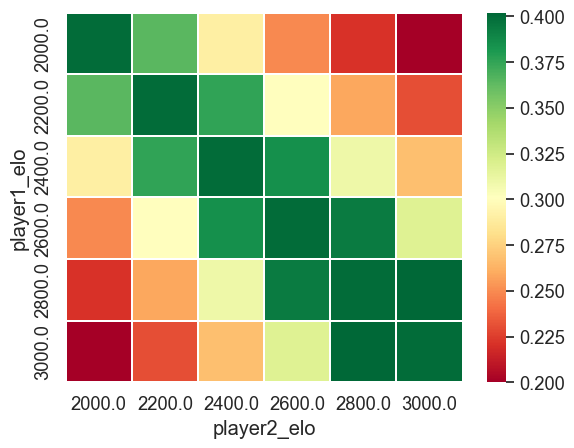

In [10]:
result = draw_probs.pivot(index='player1_elo',columns='player2_elo',values='draw_prob')
print(result)

sns.heatmap(result,cmap='RdYlGn',linewidths=0.30)
plt.show()

As can be seen in the above, the probabilities correctly flucuate between the minimum and maximum draw percentage, increase as average player ELO increases, and decrease as ELO difference increases. For example, a 3,000 ELO player has a ~40% percent chance of drawing with a 2,800 rated player, while a 2,200 ELO player has a ~36% chance of drawing with a 2000 ELO player. Despite them having the same ELO difference, the higher rated players are more likely to play a game that results in a draw. While there are of course many different ways that draw percentage could have been estimated, the results above verifies that our function is working as expected. 

### 2.2.3. ELO Changes 

The last piece that is needed before we can simulate games is to account for the fact that a player's ELO updates every time that they finish a match. The [following formulas](https://www.geeksforgeeks.org/elo-rating-algorithm/) show how to calculate the player's new ratings ($R_A'$ and $R_B'$) after they finish a game:

$$
\begin{align}
R_A' = R_A + k(O_A - E_A) \\
R_B' = R_B + k(O_B - E_A) \\
\end{align}
$$

where $O_A$ and $O_B$ are the outcomes for player $A$ and player $B$, respectively. Typically, $O_A$ and $O_B$ can only take on the following values:

* 1, if the player wins.
* 1/2, if the player draws.
* 0, if the player loses. 

Additionally, $k$ in the above equation is a scaling factor, which is typically kept at the value $k=30$. The `get_elo_change` formula below translates the above into python, and ensures that a player's new ELO cannot go outside the range of possible allowed ELO values. 

In [11]:
def get_elo_change(player1_elo, player2_elo, outcome, system):
    p = get_expected_score(player1_elo, player2_elo)
    q = 1 - p
    if outcome == 'W':
        player1_outcome = 1
        player2_outcome = 0 
    elif outcome == 'D':
        player1_outcome = 0.5
        player2_outcome = 0.5
    else:
        player1_outcome = 0
        player2_outcome = 1
    
    player1_elo = round(player1_elo + system.k * (player1_outcome - p))
    if player1_elo > system.max_elo:
        player1_elo = system.max_elo
    if player1_elo < system.min_elo:
        player1_elo = system.min_elo
        
    player2_elo = round(player2_elo + system.k * (player2_outcome - q))
    if player2_elo > system.max_elo:
        player2_elo = system.max_elo
    if player2_elo < system.min_elo:
        player2_elo = system.min_elo
    
    return player1_elo, player2_elo

We can use above formula to see what the ELO change would be 2,800 rated player who loses to a 2,600 rated player:

In [12]:
get_elo_change(2800, 2600, 'L', system)

(2778, 2622)

As we can see from the above, the 2,800 rated player lost 22 ELO points, while the 2,600 rated player gained 22 ELO points. The relatively large change is due to the fact that this is actually quite a significant ELO difference between the two players.

## 2.3 Putting It All Together
We now have all the components necessary to create a function that actually simulates a game between two players. The `play_match` function below does exactly that, and returns a W, D, or L to indicate whether the first entered player has won, drawn, or lost a match. 

In [13]:
def play_match(player1_elo, player2_elo, system):
    outcomes = ['W', 'D', 'L']
    p_W_old = get_expected_score(player1_elo, player2_elo)
    p_D = get_draw_probability(player1_elo, player2_elo, system)
    p_W_new = p_W_old - (0.5 * p_D)
    p_L = 1 - p_W_new - p_D
    #print(p_L, p_W_old, p_W_new, p_D)
    return rand.choices(outcomes, weights=[p_W_new, p_D, p_L], k=1)[0]

We can use the function above to simulate 1,000 games between a 2,800 rated and 2,600 rated opponent, and see if it aligns with expected results: 

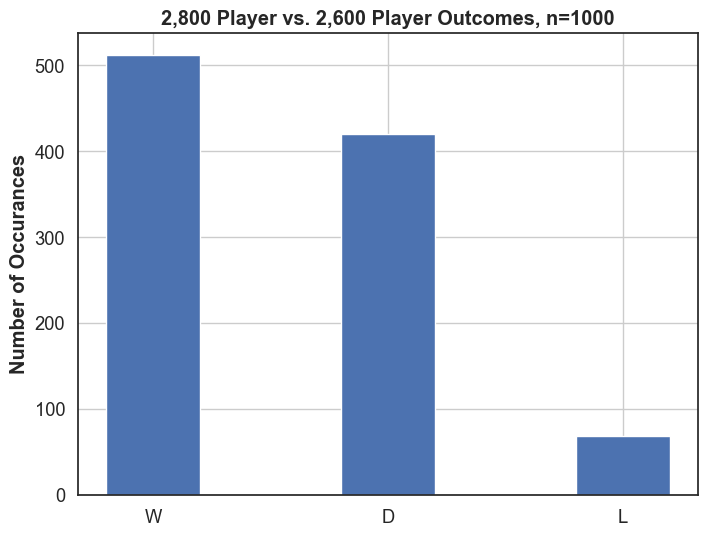

In [14]:
from collections import Counter
results = [play_match(2800, 2600, system) for i in range(1000)]
count_results = Counter(results)

plt.figure(figsize=(8,6))
plt.bar(count_results.keys(), count_results.values(), width=0.4)
plt.ylabel('Number of Occurances', fontweight='bold')
plt.title('2,800 Player vs. 2,600 Player Outcomes, n=1000', fontweight='bold')
plt.grid()

In [15]:
print(get_expected_score(2800, 2600))
print((count_results['W'] / 1000) + ((count_results['D'] / 1000) * 0.5))

0.7230037529512576
0.722


As we can see from the above, the expected score is almost exactly equal to the percentage of games the 2,800 player won plus half the percentage of the number of games the players tied. This verfifies that our function is working as expected. 

We can now combine all the functions that have been created up until this point to devise one master function that simulates the entire tournament. The `play_tournament` function below does exactly this:

In [16]:
def play_tournament(player_dicts, system):
    match_record = []
    num_players = int(system.num_players)
    outcomes = ['W', 'D', 'L']
    for rnd in range(int(system.rnds)):
        for i in range(num_players - 1):
            match_elo1 = player_dicts[i]['elo']
            for j in range(i + 1, num_players):
                match_elo2 = player_dicts[j]['elo']
                outcome = play_match(match_elo1, match_elo2, system)
                if outcome == 'W':
                    player_dicts[i]['score'] += POINTS_W
                    player_dicts[j]['score'] += POINTS_L
                elif outcome == 'D':
                    player_dicts[i]['score'] += POINTS_D
                    player_dicts[j]['score'] += POINTS_D
                else:
                    player_dicts[i]['score'] += POINTS_L
                    player_dicts[j]['score'] += POINTS_W
                new_elo1, new_elo2 = get_elo_change(match_elo1, match_elo2, outcome, system)
                player_dicts[i]['elo'] = new_elo1
                player_dicts[j]['elo'] = new_elo2
                match_record.append([player_dicts[i]['name'], player_dicts[j]['name'],
                                     match_elo1, match_elo2, new_elo1, new_elo2, outcome])
    match_record = pd.DataFrame(match_record, columns=['player1_name', 'player2_name', 'player1_match_elo', 
                                                       'player2_match_elo', 'player1_new_elo', 'player2_new_elo',
                                                       'outcome'])
    return match_record

If we use the above function on our previously created system, we get the following results:

In [17]:
player_dicts = initialize_tournament("randomize", system)
match_record = play_tournament(player_dicts, system)
player_dicts

[{'name': 'player 0', 'elo': 2446, 'score': 16},
 {'name': 'player 1', 'elo': 2521, 'score': 17},
 {'name': 'player 2', 'elo': 2151, 'score': 3},
 {'name': 'player 3', 'elo': 2910, 'score': 23},
 {'name': 'player 4', 'elo': 2615, 'score': 19},
 {'name': 'player 5', 'elo': 2266, 'score': 6},
 {'name': 'player 6', 'elo': 2370, 'score': 11},
 {'name': 'player 7', 'elo': 2304, 'score': 8},
 {'name': 'player 8', 'elo': 2374, 'score': 12},
 {'name': 'player 9', 'elo': 2145, 'score': 3}]

As expected, the higher rated players seem to have performed better than their lower rated opponents. The `play_tournament` function also provides a record of the results of every match played. The below output shows the results of the first 5 matches:

In [18]:
match_record.head()

,player1_name,player2_name,player1_match_elo,player2_match_elo,player1_new_elo,player2_new_elo,outcome
0,player 0,player 1,2440,2534,2458,2516,W
1,player 0,player 2,2440,2162,2446,2156,W
2,player 0,player 3,2440,2901,2437,2904,L
3,player 0,player 4,2440,2609,2446,2603,D
4,player 0,player 5,2440,2266,2434,2272,D


# 3. Validation

Before using our model to conduct further analysis, we must first validate that our model is working correctly. To do so, we will simulate the [results of the 2022 FIDE Candidates Chess Tournament](https://www.chess.com/events/2022-fide-candidates-chess-tournament/games). First, we initialize the tournament conditions below:

In [19]:
POINTS_W = 1
POINTS_D = 0.5
POINTS_L = 0
NUM_PLAYERS = 8
MAX_ELO = 3000
MIN_ELO = 2000
MAX_DRAW_P = 0.40
MIN_DRAW_P = 0.20
RNDS = 2
K = 30

inputs = ms.Params(points_w=POINTS_W, points_d=POINTS_D, points_l=POINTS_L,
                   num_players = NUM_PLAYERS, max_elo=MAX_ELO, min_elo=MIN_ELO,
                   max_draw_p=MAX_DRAW_P, min_draw_p=MIN_DRAW_P, rnds=RNDS, k=K)
system = ms.System(inputs)

Next, we input each of the player's names and their ELO ratings at the time they started the tournment:

In [20]:
player_dicts = [
 {'name': 'Nepomniachtchi, Ian', 'elo': 2766, 'score': 0},
 {'name': 'Ding, Liren', 'elo': 2806, 'score': 0},
 {'name': 'Radjabov, Teimour', 'elo': 2753, 'score': 0},
 {'name': 'Nakamura, Hikaru', 'elo': 2760, 'score': 0},
 {'name': 'Caruana, Fabiano', 'elo': 2783, 'score': 0},
 {'name': 'Firouzja, Alireza', 'elo': 2793, 'score': 0},
 {'name': 'Duda, Jan-Krzysztof', 'elo': 2750, 'score': 0},
 {'name': 'Rapport, Richard', 'elo': 2764, 'score': 0},
]

player_dicts

[{'name': 'Nepomniachtchi, Ian', 'elo': 2766, 'score': 0},
 {'name': 'Ding, Liren', 'elo': 2806, 'score': 0},
 {'name': 'Radjabov, Teimour', 'elo': 2753, 'score': 0},
 {'name': 'Nakamura, Hikaru', 'elo': 2760, 'score': 0},
 {'name': 'Caruana, Fabiano', 'elo': 2783, 'score': 0},
 {'name': 'Firouzja, Alireza', 'elo': 2793, 'score': 0},
 {'name': 'Duda, Jan-Krzysztof', 'elo': 2750, 'score': 0},
 {'name': 'Rapport, Richard', 'elo': 2764, 'score': 0}]

Next, we can simulate the entire tournment using only the one line of code below:

In [21]:
match_record = play_tournament(player_dicts, system)
player_dicts

[{'name': 'Nepomniachtchi, Ian', 'elo': 2766, 'score': 8.0},
 {'name': 'Ding, Liren', 'elo': 2787, 'score': 6.0},
 {'name': 'Radjabov, Teimour', 'elo': 2730, 'score': 5.0},
 {'name': 'Nakamura, Hikaru', 'elo': 2745, 'score': 5.5},
 {'name': 'Caruana, Fabiano', 'elo': 2838, 'score': 9.0},
 {'name': 'Firouzja, Alireza', 'elo': 2799, 'score': 7.5},
 {'name': 'Duda, Jan-Krzysztof', 'elo': 2779, 'score': 8.0},
 {'name': 'Rapport, Richard', 'elo': 2773, 'score': 7.0}]

Finally, we input the actual results of the tournament: 

In [22]:
actual_results = [
 {'name': 'Nepomniachtchi, Ian', 'actual_score': 9.5},
 {'name': 'Ding, Liren', 'actual_score': 8},
 {'name': 'Radjabov, Teimour', 'actual_score': 7.5},
 {'name': 'Nakamura, Hikaru', 'actual_score': 7.5},
 {'name': 'Caruana, Fabiano', 'actual_score': 6.5},
 {'name': 'Firouzja, Alireza', 'actual_score': 6},
 {'name': 'Duda, Jan-Krzysztof', 'actual_score': 5.5},
 {'name': 'Rapport, Richard', 'actual_score': 5.5}]

And compare the two:

In [23]:
pd.merge(pd.DataFrame(player_dicts), pd.DataFrame(actual_results), on='name')

,name,elo,score,actual_score
0,"Nepomniachtchi, Ian",2766,8.0,9.5
1,"Ding, Liren",2787,6.0,8.0
2,"Radjabov, Teimour",2730,5.0,7.5
3,"Nakamura, Hikaru",2745,5.5,7.5
4,"Caruana, Fabiano",2838,9.0,6.5
5,"Firouzja, Alireza",2799,7.5,6.0
6,"Duda, Jan-Krzysztof",2779,8.0,5.5
7,"Rapport, Richard",2773,7.0,5.5


We can see that while there is some variation among the final standings, the scores provided by the simulation very closely align to the player's actual scores. The range of the estimated and predicted final scores is quite similar, giving confidence that our initial conditions are accurately modelling the outcome. We can expect the results not to align exactly, given the fact that many of the players have a similar ELO level at the time they started the tournament. As such, there will be a higher degree of randomness compared to a tournament in which there is a smaller range of ELO values. 

# 4. Exploratory Analysis

Now that we have validated our model, we can perform some analysis in an attempt to generate some findings. The cell below simulates a tournament using the same system from the previous section and a randomized list of players: 

In [24]:
end_results = initialize_tournament("randomize", system)
start_results = pd.DataFrame(end_results) 
match_record = play_tournament(end_results, system)

As is to be expected, players with higher ELOs performed better in the tournament compared to their lower ELO opponents. This is shown in the scatterplot below:

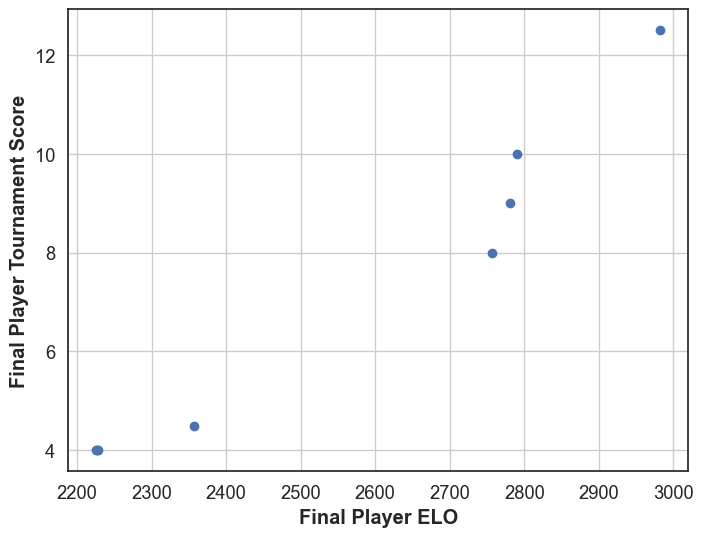

In [25]:
end_results = pd.DataFrame(end_results)

plt.figure(figsize=(8,6))
plt.scatter(end_results['elo'], end_results['score'])
plt.xlabel('Final Player ELO', fontweight='bold')
plt.ylabel('Final Player Tournament Score', fontweight='bold')
plt.grid()
plt.show()

We can also look at how ELOs changed for players over the course of the tournament: 

In [26]:
start_results.columns = ['name', 'starting_elo', 'score']
start_results = start_results.drop(columns='score')
results = pd.merge(start_results, end_results, on='name')
results['elo_change'] = results['elo'] - results['starting_elo']

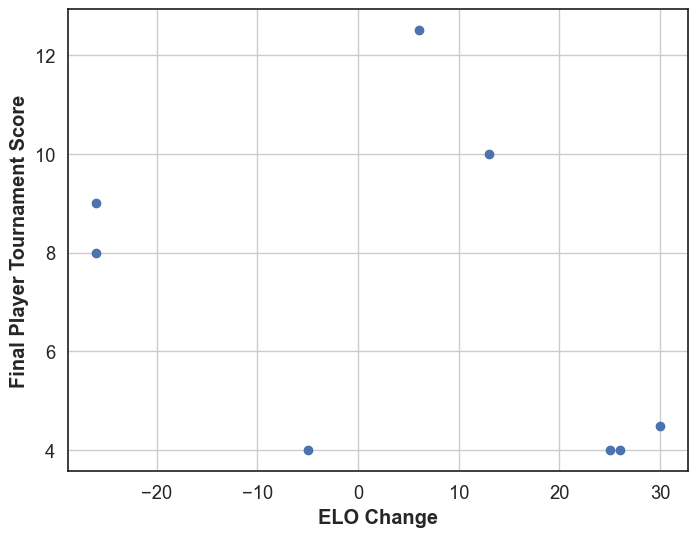

In [27]:
plt.figure(figsize=(8,6))

plt.scatter(results.elo_change, results.score)
plt.xlabel('ELO Change', fontweight='bold')
plt.ylabel('Final Player Tournament Score', fontweight='bold')
plt.grid()
plt.show()

On the surface, the above graph doesn't provide a lot of insight, so instead we can look at how ELO changes for players across a large number of tournaments in which the competition is less spread out. First, the cell below creates a function that combines some of the previous code:

In [28]:
def compare_results(system):
    end_results = initialize_tournament("randomize", system)
    start_results = pd.DataFrame(end_results) 
    match_record = play_tournament(end_results, system)
    end_results = pd.DataFrame(end_results)
    start_results.columns = ['name', 'starting_elo', 'score']
    start_results = start_results.drop(columns='score')
    results = pd.merge(start_results, end_results, on='name')
    results['elo_change'] = results['elo'] - results['starting_elo']
    return results

We can now use this function to simulate as many tournaments as desired. The cell below creates a system that changes the maximum and minimum allowed ELO from 2800 to 2650, respectively, and then plays 1000 tournaments. 

In [29]:
inputs = ms.Params(points_w=POINTS_W, points_d=POINTS_D, points_l=POINTS_L,
                   num_players = NUM_PLAYERS, max_elo=2800, min_elo=2650,
                   max_draw_p=MAX_DRAW_P, min_draw_p=MIN_DRAW_P, rnds=RNDS, k=K)

system = make_system(inputs)
elo_changes = []
starting_elos = []

for i in range(1000):
    results = compare_results(system)
    elo_changes = elo_changes + list(results['elo_change'].values)
    starting_elos = starting_elos + list(results['starting_elo'])

We can now create a histogram of the ELO changes of every player who participated in the tournaments: 

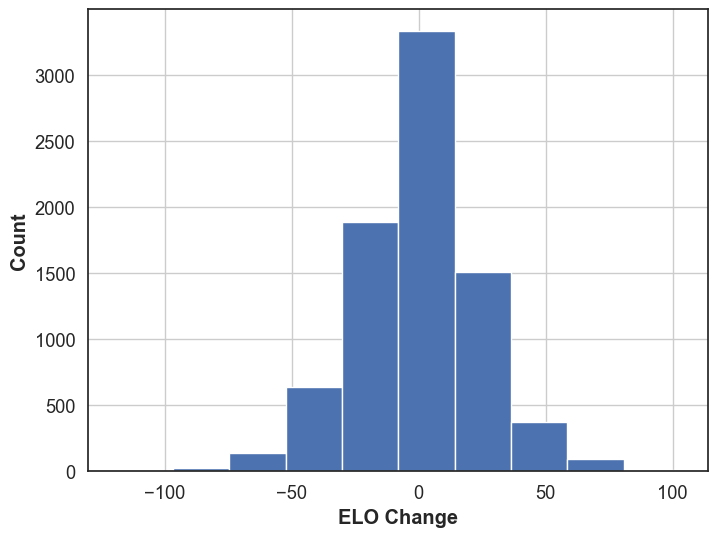

In [30]:
plt.figure(figsize=(8,6))

plt.hist(elo_changes)
plt.xlabel('ELO Change', fontweight='bold')
plt.ylabel('Count', fontweight='bold')
plt.grid()
plt.show()

According to the graph above, the ELO changes that players experience over the course of a tournament follows a normal distribution centered at 0. This is particularly interesting espeically given that players enter the tournament with varying levels of skill. The cell below checks via a scatterplot to more fully evaluate if there is any connection between starting value and ELO change:

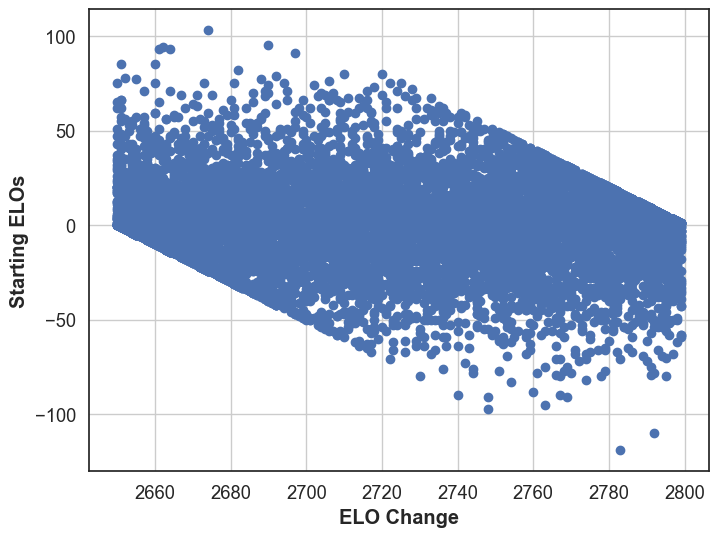

In [31]:
plt.figure(figsize=(8,6))

plt.scatter(starting_elos, elo_changes)
plt.xlabel('ELO Change', fontweight='bold')
plt.ylabel('Starting ELOs', fontweight='bold')
plt.grid()
plt.show()

# 5. So, Did He Cheat?

Now that we've created the simulation and proved that it can be used to provide analysis on the results of chess tournaments, we can finally use it to try and evaluate the claim as to whether or not Hans Niemann cheated. To do so, we first have to create a dictionary that incldudes the participants and their starting ELOs when they began the Sinquefield 2022 tournament: 

In [32]:
player_dicts = [
 {'name': 'Firouzja, Alireza', 'elo': 2778, 'score': 0},
 {'name': 'So, Wesley', 'elo': 2771, 'score': 0},
 {'name': 'Aronian, Levon', 'elo': 2759, 'score': 0},
 {'name': 'Caruana, Fabiano', 'elo': 2758, 'score': 0},
 {'name': 'Mamedyarov, Shakhriyar', 'elo': 2757, 'score': 0},
 {'name': 'Vachier-Lagrave, Maxime', 'elo': 2757, 'score': 0},
 {'name': 'Dominguez Perez, Leinier', 'elo': 2745, 'score': 0},
 {'name': 'Niemann, Hans Moke', 'elo': 2688, 'score': 0},
 {'name': 'Carlsen, Magnus', 'elo': 2861, 'score': 0},
 {'name': 'Nepomniachtchi, Ian', 'elo': 2792, 'score': 0},
]

Next, the cell below simulates tournament 5,000 times:

In [33]:
inputs = ms.Params(points_w=1, points_d=0.5, points_l=POINTS_L,
                   num_players = 10, max_elo=3000, min_elo=2600,
                   max_draw_p=MAX_DRAW_P, min_draw_p=MIN_DRAW_P, rnds=RNDS, k=K)
system = make_system(inputs)

winners = []
for i in range(5000):
    player_dicts = [
     {'name': 'Firouzja, Alireza', 'elo': 2778, 'score': 0},
     {'name': 'So, Wesley', 'elo': 2771, 'score': 0},
     {'name': 'Aronian, Levon', 'elo': 2759, 'score': 0},
     {'name': 'Caruana, Fabiano', 'elo': 2758, 'score': 0},
     {'name': 'Mamedyarov, Shakhriyar', 'elo': 2757, 'score': 0},
     {'name': 'Vachier-Lagrave, Maxime', 'elo': 2757, 'score': 0},
     {'name': 'Dominguez Perez, Leinier', 'elo': 2745, 'score': 0},
     {'name': 'Niemann, Hans Moke', 'elo': 2688, 'score': 0},
     {'name': 'Carlsen, Magnus', 'elo': 2861, 'score': 0},
     {'name': 'Nepomniachtchi, Ian', 'elo': 2792, 'score': 0},
    ]
    play_tournament(player_dicts, system)
    results = pd.DataFrame(player_dicts)
    winner = results[results['score'] == results.score.max()]['name'].values[0]
    winners.append(winner)

We can now look at a breakdown of how many times each player was predicted to win the tournament: 

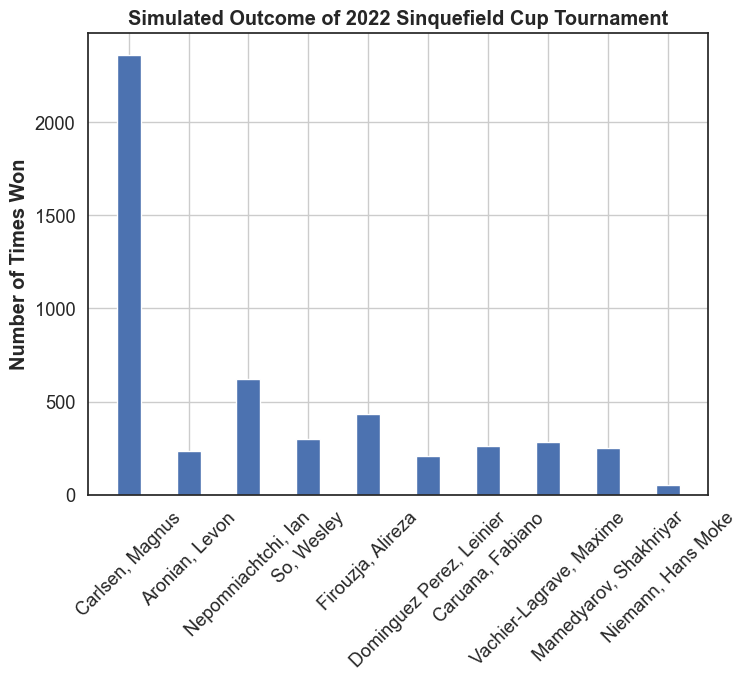

In [34]:
winner_count = Counter(winners)

plt.figure(figsize=(8,6))
plt.bar(winner_count.keys(), winner_count.values(), width=0.4)
plt.ylabel('Number of Times Won', fontweight='bold')
plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
plt.title('Simulated Outcome of 2022 Sinquefield Cup Tournament', fontweight='bold')
plt.grid()

In the above results, we see that Niemann does indeed win the tournament the least amount of times, but his chance of winning is not non-existent. Overall, he wins the torunament ~1.5% of the time. While this is a small percentage, it is not outside the relam of possibility that Niemann could pull off a tournament win. 

We can also use one of our helper functions to simulate games played between only Niemann and Carlsen. The cell below simulates 1,000 games between them using their starting ELOs in the tournament:

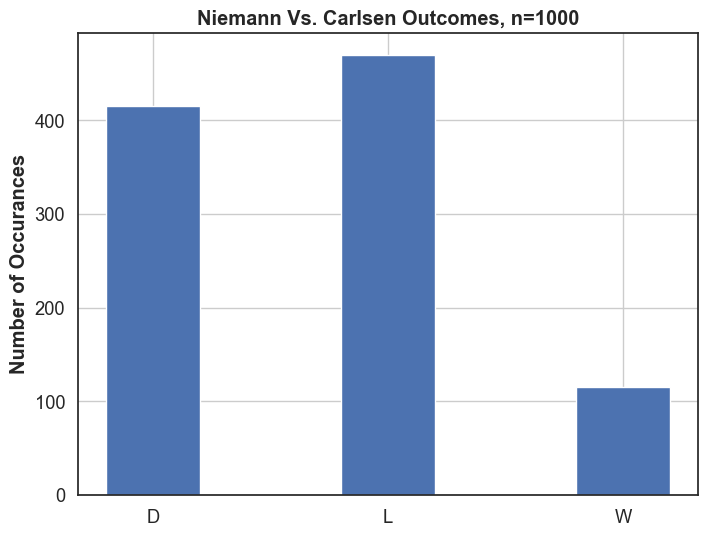

In [35]:
from collections import Counter
results = [play_match(2688, 2861, system) for i in range(1000)]
count_results = Counter(results)

plt.figure(figsize=(8,6))
plt.bar(count_results.keys(), count_results.values(), width=0.4)
plt.ylabel('Number of Occurances', fontweight='bold')
plt.title('Niemann Vs. Carlsen Outcomes, n=1000', fontweight='bold')
plt.grid()

While Niemann does expectedly lose or draw most of his games against Carlsen, he does win approximately 10% of the time.

# 6. Conclusion 

The work presented here provides the a way to simulate chess the results of chess tournaments, and through the process of verification and validation shows that it can provide meaningful insight into their actual outcomes. The initial motivation of this work was to provide a way to investigate cheating claims during live chess matches, but the above results show that this simulation can also provide more generalized insights the into the results of chess matches. 

As to whether or not Niemann cheated in his game against Carlsen, we will never likely know the full story. However, the results shown here prove that, while it is improbable, Niemann is perfectly capable of not just beating Carlsen in a chess game, but also has the ability to win a chess tournament in which they are both participants. It's possible that Carlsen has other reasons for believing that Niemann cheated, but they are not evident in the results presented above. 